In [1]:
import os
import itertools
import xlsxwriter

import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm 
import matplotlib.pyplot as plt

import Simulations as sim
import Models
from MyEstimators import CLS_Estimator

In [2]:
# Number of gamma parameters
orders =  {'sin_func':1,
               'cos_func':1,
               'scaled_sin_func':1,
               'scaled_cos_func':2,
               'exp_func':2,
               'exp_shift_func':2,
                'poly_func':3,
                'linear_func':2
               }
extra_params = orders

In [3]:
def constraint_func(x):
    def constraint(params):
        con = 0
        for j in np.arange(0, x.shape[1]):
            con += params[j]**2
            cons = con - 1
        return cons
    return {'type':'eq', 'fun': constraint}

In [32]:
parameters = {'theta': [0.6, -0.8],
              'beta': [0.5, 1],
              'gamma': [0.2, 0.3, 0.3]
              }

In [33]:
data, y, y_lag, x, z = sim.xy_generator(parameters=parameters, sample_size=1000, function=Models.scaled_sin_func,
                          stationary=False, constraints=True)

In [34]:
variables = pd.DataFrame(x)
station = pd.DataFrame(np.concatenate((y_lag, z), axis = 1))
y = pd.DataFrame(y)
y_lag = pd.DataFrame(y_lag)

In [35]:
test = 0
for i in x:
    if np.sqrt(i[0]**2+i[1]**2) <= np.sqrt(1000):
        test += 1
test

661

In [37]:
for i in x:
    print(np.sqrt(i[0]**2+i[1]**2))

9.722930518690767
9.258204754308656
9.005773628952404
10.366368254366733
11.090225103627041
10.91511706584741
8.814779600685444
8.437717182498323
8.67444186576831
9.786907281214491
8.17517606182758
8.806043761906796
6.702298116824348
5.379998164677623
4.90352809696486
3.5861690183906867
4.547984392607687
4.986338508955084
7.761603207110688
9.328197028920544
8.453892359131526
9.142551827458789
8.160496370658013
8.958272039229524
8.36866534502873
6.73827321458603
8.573831559022445
8.503032854760928
9.483971252827358
8.008616765871228
6.00605984253694
6.621169706659617
5.408033365486007
6.6117998744665885
9.020262865001932
8.538767329137864
8.610679510364797
11.16023682444213
13.924805284815257
13.555979912147828
16.616153290796884
20.102375997271356
22.055498616630434
22.63846555778371
25.469933682116988
24.78092433990841
24.862924712309173
22.489940168558725
19.98862025556718
19.51371310730504
20.117470398959583
19.43320344330191
20.34754923956519
20.032735107924744
18.174596190809215
1

In [38]:
def Taylor_init(variables, station, y, function):
    
    Models.param_num = {'theta':variables.shape[1],
               'beta':station.shape[1],
               'gamma':extra_params[function.__name__]
               }
    
    d1, d2, extra = Models.param_num['theta'], Models.param_num['beta'], Models.param_num['gamma']
    
    # find the initials for theta
    LR = LinearRegression()
    LR_theta = LR.fit(variables.iloc[:,1:], variables.iloc[:,:1])
    alpha = np.append(1, -LR_theta.coef_)
    theta = np.array(alpha/np.linalg.norm(alpha))
    
    # calculate single-index
    u = Models.single_index(variables.values)(theta)
#     print(u)
    
    # find the initials for beta
    Xs = station.copy()
    Xs['u'], Xs['u2'], Xs['u3'], Xs['u4'], Xs['u6'] = u, u**2, u**3, u**4, u**6
    t_order = orders.get(function.__name__)
    
    if function == Models.exp_func:
        X_reg = Xs.iloc[:, 0:d2+t_order].drop(['u', 'u3'], axis = 1)
    else:
        X_reg = Xs.iloc[:, 0:d2+t_order]
#     print(X_reg)
    LR_taylor = LR.fit(X_reg, y)
    theta_beta = np.append(theta,LR_taylor.coef_[0][:d2])
    print(LR_taylor.coef_[0])
    
    # initials for gammas
    initials = []
    if function == Models.sin_func:
        initials = np.append(theta_beta, LR_taylor.intercept_)
    elif function == Models.scaled_sin_func:
        initials = np.append(theta_beta, ([LR_taylor.coef_[0][-1]], [LR_taylor.intercept_[0]]))
    elif function == Models.linear_func:
        initials = np.append(theta_beta, ([LR_taylor.intercept_], [LR_taylor.coef_[0]]))
    elif function == Models.poly_func:
        ini_poly_ = np.append(theta_beta,LR_taylor.coef_[0][d2:])
        initials = np.insert(ini_poly_, 4, LR_taylor.intercept_)
    elif function == Models.cos_func:
        initials = np.append(theta_beta, [-LR_taylor.coef_[-1]/2])
#         print(-LR_taylor.coef_[-1]/2, -LR_taylor.coef_[d2])
    elif function == Models.scaled_cos_func:
        initials = np.append(theta_beta,(
            [-LR_taylor.coef_[d2]/2*np.sqrt(np.abs(1-LR_taylor.intercept_)),np.sqrt(np.abs(1-LR_taylor.intercept_))]))
#         print(1-LR_taylor.intercept_)
    elif function == Models.exp_shift_func:
        initials = np.append(theta_beta, 
                             [np.sqrt(np.abs(LR_taylor.coef_[-1])),LR_taylor.coef_[-2]/np.sqrt(np.abs(LR_taylor.coef_[-1]))])
#         print(LR_taylor.coef_, LR_taylor.coef_[-2])
    elif function == Models.exp_func:
        initials =np.append(theta_beta, [LR_taylor.intercept_, -LR_taylor.coef_[-3]])
#         initials =np.append(theta_beta, [LR_taylor.intercept_, np.sqrt(np.abs(2*LR_taylor.coef_[-2]/(LR_taylor.intercept_)))])
#     print(initials)
    return initials

In [39]:
initials = Taylor_init(variables, station, y, Models.scaled_sin_func)

[0.50026333 0.99989569 0.28457624]


In [40]:
initials

array([ 0.60011008, -0.79991743,  0.50026333,  0.99989569,  0.28457624,
        0.19344586])

In [41]:
initials_p = Taylor_init(variables, station, y, Models.poly_func)

[ 0.50001061  1.0000069   0.29384003 -0.00867483 -0.00425067]


In [11]:
# parameters = {'theta': [0.6, -0.8],
#               'beta': [0.05, 1],
#               'gamma': [0.2, 0.3, -0.3]
#               }

[3.18787518e-01 5.01734325e-01 9.99905890e-01 3.10552730e-05]
[ 1.35586983e-01  5.06771507e-01  9.85159225e-01 -4.33063686e-04]
[0.01755197 0.502029   0.98742986 0.12057802]
[0.05750618 0.49279937 0.99367415 0.13521058]
[0.3226946  0.50071238 1.00025194 0.20679682]
[0.22230271 0.50308158 1.00055587 0.23734176]
[0.2761612  0.50007719 1.00267752 0.02544997]
[0.37719098 0.50006725 1.00158973 0.13808385]
[0.08808745 0.49765227 0.99401244 0.00215709]
[ 1.47269770e-01  4.99293470e-01  9.99097958e-01 -5.60737606e-04]
[0.43349055 0.50112666 1.00540398 0.05797914]
[-0.17704541  0.49894509  0.998364    0.14526707]
[0.29420969 0.49704012 0.99926347 0.14143721]
[-0.0406499   0.49919078  0.99612028  0.00870086]
[0.00182087 0.49641361 1.00412523 0.20020897]
[0.00583345 0.49970748 1.00291295 0.11244239]
[0.35860439 0.49598528 1.00965117 0.08631207]
[0.16484744 0.50232042 0.99803764 0.20611635]
[0.23810663 0.50069029 0.99675322 0.00664721]
[-0.00627315  0.49956993  0.99977032  0.07742529]


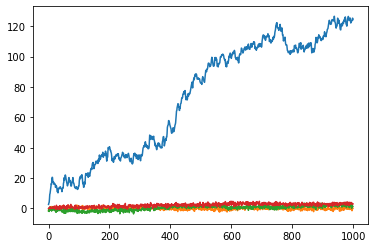

In [90]:
i = 0
t_beta1 = []
t_beta2 = []
t_gamma1 = []
t_gamma2 = []

while i < 1000:
    data, y, y_lag, x, z = sim.xy_generator(parameters=parameters, sample_size=1000, function=Models.scaled_sin_func,
                          stationary=False, constraints=True)
    station = pd.DataFrame(np.concatenate((y_lag, z), axis = 1))
    try:
        with np.errstate(all='raise'):
            cls = CLS_Estimator(obj_func = Models.scaled_sin_func, x0 = initials, 
                    constraints = constraint_func(variables)) 
            cls.fit(data[:,:4],y.reshape(-1,1))
            theta_hat = cls.params_[:2]
    except Exception:
        print("Warning detected")
        continue

    u_hat = Models.single_index(x)(theta_hat)

    
    _X = sm.add_constant(station)
    X = np.concatenate((_X,np.array([u_hat]).T), axis = 1)
    model = sm.OLS(y.reshape(-1,1), X)
    results = model.fit()
    if i%50 == 0:
        print(results.params)
    if i%250 == 0:
        plt.plot(u_hat)
    t_gamma2.append(results.tvalues[0])
    t_gamma1.append(results.tvalues[-1])
    t_beta1.append(results.tvalues[1])
    t_beta2.append(results.tvalues[2])
    i = i+1

In [91]:
list_g1 = [1 if np.abs(i)<1.64 else 0 for i in t_gamma1]
list_g2 = [1 if np.abs(i)<1.64 else 0 for i in t_gamma2]
list_b1 = [1 if np.abs(i)<1.64 else 0 for i in t_beta1]
list_b2 = [1 if np.abs(i)<1.64 else 0 for i in t_beta2]

In [92]:
np.sum(list_g1)/len(list_g1)

0.128

In [93]:
np.sum(list_g2)/len(list_g1)

0.042

In [94]:
np.sum(list_b1)/len(list_g1)

0.0

In [95]:
np.sum(list_b2)/len(list_g1)

0.0

In [31]:
results.tvalues

array([ 11.58013931, 155.84382721, 179.53803565,  11.08699409])

In [47]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.627
Method:                 Least Squares   F-statistic:                     560.8
Date:                Thu, 04 Nov 2021   Prob (F-statistic):          2.24e-213
Time:                        16:19:19   Log-Likelihood:                -1478.9
No. Observations:                1000   AIC:                             2966.
Df Residuals:                     996   BIC:                             2985.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0878      0.067     -1.306      0.192      -0.220       0.044
x1             0.7812      0.020     39.810      0.000       0.743       0.820
x2             0.0075      0.004      1.805      0.071      -0.001       0.016
x3             0.2269      0.046      4.913      0.000       0.136       0.318
==============================================================================
Omnibus:                        2.036   Durbin-Watson:                   1.598
Prob(Omnibus):                  0.361   Jarque-Bera (JB):                1.896
Skew:                          -0.094   Prob(JB):                        0.388
Kurtosis:                       3.100   Cond. No.                         25.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

[ 0.19623725  0.50001363  0.9999791   0.28897937 -0.00379709]
[ 0.192875    0.49988838  1.00014771  0.31653639 -0.02755474]
[ 0.20107837  0.49999167  1.00000922  0.29797095 -0.02014913]
Warning detected
[ 0.19554094  0.5000576   0.99985678  0.28976754 -0.00244482]
[ 0.19693328  0.49988753  1.00021508  0.28820623 -0.00532794]
Warning detected
[ 0.19983907  0.5000195   1.00003508  0.28764422 -0.01070977]
Warning detected
[ 0.19588473  0.50006806  0.99993058  0.28904608 -0.0034169 ]
[ 0.19737193  0.49992583  1.00012835  0.30908886 -0.02518452]
[ 0.19358668  0.49998495  1.00005898  0.3159466  -0.02750619]
[ 0.19909332  0.49997721  1.00007498  0.30415839 -0.02314229]
[ 0.19857742  0.49987352  1.00008741  0.287325   -0.00839036]
Warning detected
[ 0.20107315  0.50000081  1.00003326  0.29876522 -0.0206864 ]
Warning detected
Warning detected
[ 0.183673    0.49999198  0.99997669  0.32865075 -0.03102812]
Warning detected
[ 0.19646039  0.49990088  1.00010027  0.28970512 -0.00362262]
[0.19764494 0

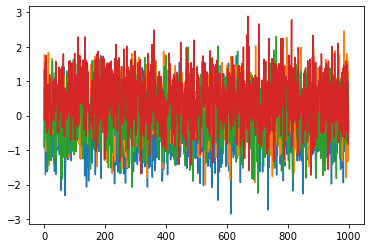

In [81]:
i = 0
t_beta1_p = []
t_beta2_p = []
t_gamma1_p = []
t_gamma2_p = []
t_gamma3_p = []
f_pvalue = []

while i < 1000:
    dt, y, y_lag, x, z = sim.xy_generator(parameters=parameters, sample_size=1000, function=Models.scaled_sin_func,
                          stationary=False, constraints=True)
    station = pd.DataFrame(np.concatenate((y_lag, z), axis = 1))
    try:
        with np.errstate(all='raise'):
            cls = CLS_Estimator(obj_func = Models.poly_func, x0 = initials_p, 
                    constraints = constraint_func(variables))
#             cls = CLS_Estimator(obj_func = Models.scaled_sin_func, x0 = parameters['theta']+parameters['beta']+parameters['gamma'], 
#                     constraints = constraint_func(variables))
            cls.fit(dt[:,:4],y.reshape(-1,1))
            theta_hat = cls.params_[:2]
    except Exception:
        print("Warning detected")
        continue
        
    u_hat = Models.single_index(dt[:,:2])([0.6,-0.8])
    
    _X = sm.add_constant(dt[:,2:4])
    X = np.concatenate((_X,np.array([u_hat]).T, np.array([u_hat**2]).T), axis = 1)
#     X = np.concatenate((_X,np.array([u_hat]).T), axis = 1)
    model = sm.OLS(dt[:,4:5].reshape(-1,1), X)
    results = model.fit()
    if i%50 == 0:
        print(results.params)
    if i%250 == 0:
        plt.plot(u_hat)
    R = [[0, 0, 0, 1, 0], [0, 0, 0, 0,1]]
    ft = results.f_test(R)
    f_pvalue.append(ft.pvalue)
    t_gamma1_p.append(results.tvalues[0])
    t_gamma2_p.append(results.tvalues[-2])
    t_gamma3_p.append(results.tvalues[-1])
    t_beta1_p.append(results.tvalues[1])
    t_beta2_p.append(results.tvalues[2])
    i = i+1

In [82]:
list_g1_p = [1 if np.abs(i)>1.96 else 0 for i in t_gamma1_p]
list_g2_p = [1 if np.abs(i)>1.96 else 0 for i in t_gamma2_p]
list_g3_p = [1 if np.abs(i)>1.96 else 0 for i in t_gamma3_p]
list_b1_p = [1 if np.abs(i)>1.96 else 0 for i in t_beta1_p]
list_b2_p = [1 if np.abs(i)>1.96 else 0 for i in t_beta2_p]
f_p = [1 if i<0.05 else 0 for i in f_pvalue]

In [83]:
i

1000

In [84]:
np.sum(list_b1_p)/i

1.0

In [85]:
np.sum(list_b2_p)/i

1.0

In [86]:
np.sum(list_g1_p)/i

1.0

In [87]:
np.sum(list_g2_p)/i

1.0

In [88]:
np.sum(list_g3_p)/i

0.986

In [89]:
np.sum(f_p)/i

1.0

In [96]:
i = 0
t_beta1 = []
t_beta2 = []
t_alpha1 = []
t_alpha2 = []
t_gamma1 = []

while i < 1000:
    data, y, y_lag, x, z = sim.xy_generator(parameters=parameters, sample_size=1000, function=Models.scaled_sin_func,
                          stationary=False, constraints=True)
    station = pd.DataFrame(np.concatenate((y_lag, z), axis = 1))
    
    _X = sm.add_constant(station)
    X = np.concatenate((_X,x), axis = 1)
    model = sm.OLS(y.reshape(-1,1), X)
    results = model.fit()
    if i%50 == 0:
        print(results.params)
    t_gamma1.append(results.tvalues[0])
    t_alpha1.append(results.tvalues[-2])
    t_alpha2.append(results.tvalues[-1])
    t_beta1.append(results.tvalues[1])
    t_beta2.append(results.tvalues[2])
    i = i+1

[ 0.1941045   0.50006371  0.99998405  0.17178153 -0.22907594]
[ 0.19567475  0.49987354  1.00022096  0.17568383 -0.23423229]
[ 0.19563683  0.49998875  1.00017181  0.16705912 -0.22274494]
[ 0.20741132  0.50046114  0.99880834  0.15680397 -0.20906784]
[ 0.19503225  0.50000877  0.99994265  0.17571576 -0.234295  ]
[ 0.19404356  0.50012482  0.99977243  0.17130233 -0.22841654]
[ 0.19491498  0.4999724   0.99977754  0.16846941 -0.22463442]
[ 0.19481857  0.50000635  0.99989063  0.17553302 -0.23405201]
[ 0.1946283   0.49997963  1.00011018  0.1685816  -0.22478082]
[ 0.19533442  0.50009194  0.99991014  0.17604175 -0.2347308 ]
[ 0.20146575  0.50013804  0.99981201  0.16145271 -0.21521448]
[ 0.19515591  0.50005859  0.99981676  0.1756808  -0.23423614]
[ 0.19413876  0.49989047  0.9999774   0.17465042 -0.23285431]
[ 0.19497344  0.5000897   0.99979611  0.17551567 -0.23402485]
[ 0.19356795  0.50007085  1.00009022  0.17193424 -0.22924265]
[ 0.19382443  0.50003287  1.00006877  0.17135126 -0.22850658]
[ 0.1941

In [97]:
list_g1 = [1 if np.abs(i)>1.96 else 0 for i in t_gamma1]
list_a1 = [1 if np.abs(i)>1.96 else 0 for i in t_alpha1]
list_a2 = [1 if np.abs(i)>1.96 else 0 for i in t_alpha2]
list_b1 = [1 if np.abs(i)>1.96 else 0 for i in t_beta1]
list_b2 = [1 if np.abs(i)>1.96 else 0 for i in t_beta2]

In [98]:
np.sum(list_g1)/i

1.0

In [99]:
np.sum(list_a1)/i

1.0

In [100]:
np.sum(list_a2)/i

1.0

In [101]:
np.sum(list_b1)/i

1.0

In [102]:
np.sum(list_b2)/i

1.0

In [ ]:
Taylor_init(variables, station, y, Models.poly_func)

In [ ]:
extra_params = {'sin_func':1,
               'cos_func':1,
               'scaled_sin_func':2,
               'scaled_cos_func':2,
               'exp_func':2,
               'exp_shift_func':2,
                'poly_func':3,
                'linear_func':2
               }

In [ ]:
Models.param_num= {'theta': 2,
              'beta': 2,
              'gamma': 2
              }

In [ ]:
cls.fit(dt[:,:4],dt[:,4:5].reshape(-1,1))

In [ ]:
uhat = np.array([u_hat]).T

In [ ]:
X = np.concatenate((X,np.array([u_hat]).T), axis = 1)

In [ ]:
X = sm.add_constant(dt[:,:2])

In [ ]:
model = sm.OLS(y, X)
results = model.fit()
results.tvalues

In [ ]:
results.tvalues